# Market Intelligence Demo

This notebook demonstrates the full `MarketIntelligence` system, which orchestrates:

1. **RegimeAnalyzer** - Detect current market context (bull/bear/crisis/sideways)
2. **AutoPilot** - Automatically select the best analysis pipeline
3. **Explainer** - Generate actionable reports with Markdown export

The system uses real-time data from Yahoo Finance and produces end-to-end analysis with a single API call.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

print('Setup complete.')

Setup complete.


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['figure.dpi'] = 100

print('Plotting style configured.')

Plotting style configured.


---
## 1. Full Analysis: BTC-USD

The `analyze()` method runs the complete pipeline:
1. Fetch price data
2. Detect market regime
3. Select pipeline (conservative/aggressive/crisis/trend_following)
4. Fit model and generate forecast
5. Compile report

In [3]:
from timeseries_toolkit.intelligence import MarketIntelligence

mi = MarketIntelligence()

report = mi.analyze(['BTC-USD'], horizon='7D', verbose=True)

print('\n' + '=' * 60)
print('ANALYSIS COMPLETE')
print('=' * 60)

[1/5] Fetching data for ['BTC-USD']...


[2/5] Detecting market regime...


[3/5] Selecting pipeline...


[4/5] Running aggressive pipeline...


[5/5] Skipping driver analysis (single asset).

ANALYSIS COMPLETE


### 1.1 Report Summary

In [4]:
print('Summary:')
print(report.summary)
print()
print(f'Pipeline used: {report.pipeline_used}')
print(f'Pipeline reason: {report.pipeline_reason}')
print(f'Assets: {report.assets}')
print(f'Horizon: {report.horizon}')
print(f'Data range: {report.data_range}')
print(f'Observations: {report.observations_used}')

Summary:
MARKET REGIME: Bull (100% confidence)

BTC-USD 7D Outlook: $87,879.12 -> $87,946.04 (+0.1%)
Confidence: LOW

Key Factors:
  - Regime transition risk elevated (52%)
  - 2 of 4 diagnostic tests failed

Quality: LOW (2/4 diagnostics pass)
Risk: 52% chance of regime shift within 14 days

Pipeline used: aggressive
Pipeline reason: Data is non-stationary (ADF p > 0.05); optimal fractional d=0.50. Fractional differentiation preserves long memory while achieving stationarity (López de Prado 2018).
Assets: ['BTC-USD']
Horizon: 7D
Data range: 2025-01-29 to 2026-01-29
Observations: 366


### 1.2 Regime Detection Results

In [5]:
if report.regime:
    regime = report.regime
    print(f'Current regime:     {regime.current_regime}')
    print(f'Confidence:         {regime.confidence:.1%}')
    print(f'Days in regime:     {regime.days_in_regime}')
    print(f'Transition risk:    {regime.transition_risk:.1%}')
    print(f'\nRegime probabilities:')
    for name, prob in regime.regime_probabilities.items():
        bar = '#' * int(prob * 40)
        print(f'  {name:10s}: {prob:.1%} {bar}')
else:
    print('Regime detection was not performed.')

Current regime:     bull
Confidence:         100.0%
Days in regime:     3
Transition risk:    52.4%

Regime probabilities:
  bull      : 100.0% ########################################
  bear      : 0.0% 
  crisis    : 0.0% 


### 1.3 Forecast

In [6]:
if report.forecast is not None and not report.forecast.empty:
    print('7-Day Forecast:')
    print(report.forecast.to_string())
    
    # Direction and magnitude
    first_val = report.forecast['forecast'].iloc[0]
    last_val = report.forecast['forecast'].iloc[-1]
    current = report.current_prices.get('BTC-USD', first_val)
    pct = (last_val / current - 1) * 100
    print(f'\nCurrent price: ${current:,.0f}')
    print(f'Day 7 forecast: ${last_val:,.0f}')
    print(f'Expected change: {pct:+.2f}%')
else:
    print('No forecast available.')

7-Day Forecast:
               forecast         lower         upper
2026-01-30  87946.03577  87656.333687  88235.737852
2026-01-31  87946.03577  87536.335156  88355.736384
2026-02-01  87946.03577  87444.257044  88447.814496
2026-02-02  87946.03577  87366.631605  88525.439935
2026-02-03  87946.03577  87298.242220  88593.829320
2026-02-04  87946.03577  87236.413490  88655.658050
2026-02-05  87946.03577  87179.556105  88712.515435

Current price: $87,879
Day 7 forecast: $87,946
Expected change: +0.08%


### 1.4 Warnings and Recommendations

In [7]:
if report.warnings:
    print('Warnings:')
    for w in report.warnings:
        print(f'  - {w}')
else:
    print('No warnings.')

print()
if report.recommendations:
    print('Recommendations:')
    for r in report.recommendations:
        print(f'  - {r}')
else:
    print('No recommendations.')

Warnings:
  - Regime transition risk elevated (52%)
  - 2 of 4 diagnostic tests failed

Recommendations:
  - Trend-following strategies may be effective in bull regime


### 1.5 Quality Score

In [8]:
print(f'Quality score: {report.quality_score:.2f} / 1.00')

if report.diagnostics:
    diag = report.diagnostics
    print(f'\nDiagnostics:')
    print(f'  Residual mean: {diag.residual_mean:.6f}')
    print(f'  Residual std:  {diag.residual_std:.6f}')
    print(f'  Tests passed:  {diag.pass_count}/{diag.total_tests}')

Quality score: 0.50 / 1.00

Diagnostics:
  Residual mean: 0.000000
  Residual std:  147.809901
  Tests passed:  2/4


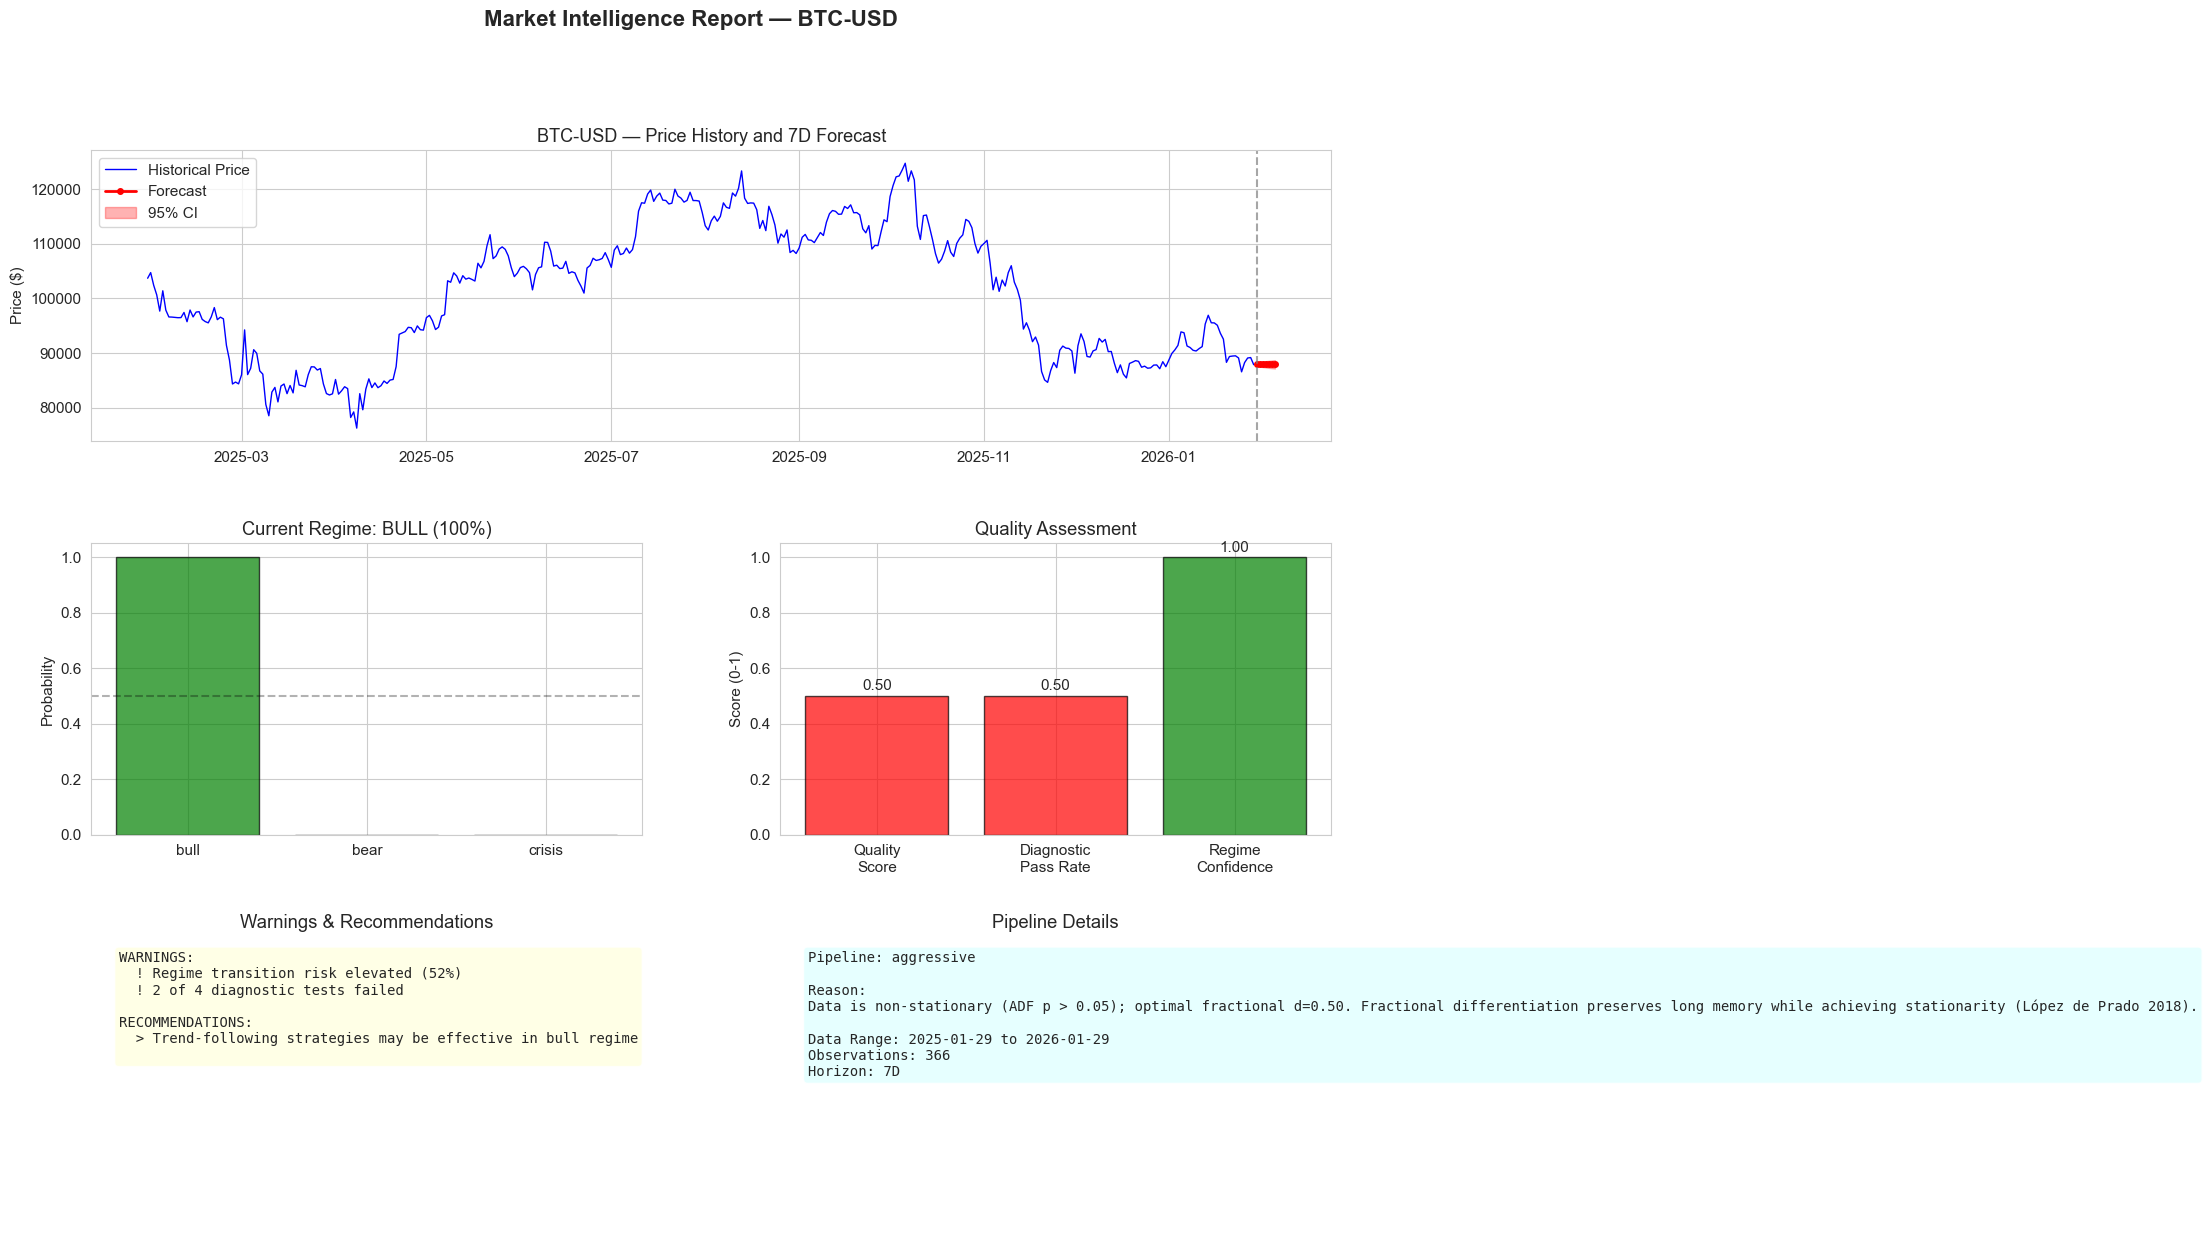

In [9]:
# ── Market Intelligence Dashboard ──
from timeseries_toolkit.data_sources import CryptoDataLoader as _CL

# Fetch historical prices for plotting (report doesn't store them)
_crypto = _CL()
_btc_hist = _crypto.get_prices(['BTC-USD'], period='1y')
_btc_prices = _btc_hist[[c for c in _btc_hist.columns if 'Close' in c or 'close' in c][0]]

fig = plt.figure(figsize=(16, 14))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.25)

# ── Panel 1: Price History + Forecast (top, full width) ──
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(_btc_prices.index, _btc_prices.values, label='Historical Price', color='blue', linewidth=1)
if report.forecast is not None and not report.forecast.empty:
    fc = report.forecast
    ax1.plot(fc.index, fc['forecast'], label='Forecast', color='red', linewidth=2, marker='o', markersize=4)
    ax1.fill_between(fc.index, fc['lower'], fc['upper'], alpha=0.3, color='red', label='95% CI')
    ax1.axvline(x=fc.index[0], color='gray', linestyle='--', alpha=0.7)
ax1.set_title(f'BTC-USD — Price History and {report.horizon} Forecast', fontsize=13)
ax1.set_ylabel('Price ($)')
ax1.legend(loc='upper left')

# ── Panel 2: Regime Probabilities ──
ax2 = fig.add_subplot(gs[1, 0])
if report.regime:
    regime = report.regime
    reg_names = list(regime.regime_probabilities.keys())
    reg_probs = list(regime.regime_probabilities.values())
    reg_colors = {'bull': 'green', 'bear': 'red', 'crisis': 'orange', 'sideways': 'gray'}
    colors = [reg_colors.get(r, 'steelblue') for r in reg_names]
    ax2.bar(reg_names, reg_probs, color=colors, alpha=0.7, edgecolor='black')
    ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
    ax2.set_ylim(0, 1.05)
    ax2.set_title(f'Current Regime: {regime.current_regime.upper()} ({regime.confidence:.0%})')
    ax2.set_ylabel('Probability')
else:
    ax2.text(0.5, 0.5, 'Regime detection\nnot available', ha='center', va='center',
             transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Regime Probabilities')

# ── Panel 3: Quality Metrics ──
ax3 = fig.add_subplot(gs[1, 1])
quality_labels = ['Quality\nScore', 'Diagnostic\nPass Rate', 'Regime\nConfidence']
quality_values = [
    report.quality_score,
    report.diagnostics.pass_count / max(report.diagnostics.total_tests, 1) if report.diagnostics else 0,
    report.regime.confidence if report.regime else 0,
]
q_colors = ['green' if v > 0.7 else 'orange' if v > 0.5 else 'red' for v in quality_values]
ax3.bar(quality_labels, quality_values, color=q_colors, alpha=0.7, edgecolor='black')
ax3.set_ylim(0, 1.05)
ax3.set_title('Quality Assessment')
ax3.set_ylabel('Score (0-1)')
for i, v in enumerate(quality_values):
    ax3.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=11)

# ── Panel 4: Warnings & Recommendations ──
ax4 = fig.add_subplot(gs[2, 0])
info_text = "WARNINGS:\n"
if report.warnings:
    for w in report.warnings:
        info_text += f"  ! {w}\n"
else:
    info_text += "  None\n"
info_text += "\nRECOMMENDATIONS:\n"
if report.recommendations:
    for r in report.recommendations:
        info_text += f"  > {r}\n"
else:
    info_text += "  None\n"
ax4.text(0.05, 0.95, info_text, fontsize=10, family='monospace',
         verticalalignment='top', transform=ax4.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
ax4.axis('off')
ax4.set_title('Warnings & Recommendations')

# ── Panel 5: Pipeline Info ──
ax5 = fig.add_subplot(gs[2, 1])
pipeline_text = (
    f"Pipeline: {report.pipeline_used}\n\n"
    f"Reason:\n{report.pipeline_reason[:200]}\n\n"
    f"Data Range: {report.data_range}\n"
    f"Observations: {report.observations_used}\n"
    f"Horizon: {report.horizon}"
)
ax5.text(0.05, 0.95, pipeline_text, fontsize=10, family='monospace',
         verticalalignment='top', transform=ax5.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.8))
ax5.axis('off')
ax5.set_title('Pipeline Details')

plt.suptitle('Market Intelligence Report — BTC-USD', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpretation:** This dashboard summarizes the full MarketIntelligence analysis. The **top panel** shows historical prices alongside the 7-day forecast with confidence intervals — the widening band reflects growing uncertainty. The **regime panel** (middle-left) shows the probability distribution across market states, with the current regime highlighted. **Quality metrics** (middle-right) assess forecast reliability: quality score, diagnostic pass rate, and regime confidence. A quality score below 0.7 warrants caution. The bottom panels provide **actionable warnings** and **pipeline selection rationale** — explaining why the system chose this particular analysis approach.

---
## 2. Quick Forecast: SPY

The `quick_forecast()` method skips regime detection and causal analysis for faster results.

In [10]:
spy_fc = mi.quick_forecast('SPY', horizon='7D')

print('SPY Quick Forecast (7 days):')
print(spy_fc.to_string())

SPY Quick Forecast (7 days):
              forecast       lower       upper
2026-01-29  695.396985  693.947771  696.846200
2026-01-30  695.396985  693.347486  697.446484
2026-01-31  695.396985  692.886872  697.907098
2026-02-01  695.396985  692.498556  698.295414
2026-02-02  695.396985  692.156443  698.637527
2026-02-03  695.396985  691.847149  698.946821
2026-02-04  695.396985  691.562724  699.231246


---
## 3. Regime Detection Only

Use `get_regime()` when you only need the market context without forecasting.

In [11]:
regime = mi.get_regime(['SPY'])

print('SPY Market Regime:')
print(f'  Current:        {regime.current_regime}')
print(f'  Confidence:     {regime.confidence:.1%}')
print(f'  Days in regime: {regime.days_in_regime}')
print(f'  Transition risk: {regime.transition_risk:.1%}')

SPY Market Regime:
  Current:        bull
  Confidence:     86.4%
  Days in regime: 6
  Transition risk: 22.3%


---
## 4. Multi-Asset Comparison

Compare BTC and SPY side-by-side with correlation analysis.

In [12]:
comparison = mi.compare_assets(['BTC-USD', 'SPY'], horizon='7D')

print('Asset Comparison: BTC-USD vs SPY')
print()

if comparison.correlations is not None:
    print('Return Correlations:')
    print(comparison.correlations.to_string())
    print()

if comparison.relative_strength is not None:
    print('30-Day Relative Strength:')
    print(comparison.relative_strength.to_string())
    print()

for asset, rpt in comparison.individual_reports.items():
    print(f'\n--- {asset} ---')
    print(f'  Pipeline: {rpt.pipeline_used}')
    if rpt.regime:
        print(f'  Regime:   {rpt.regime.current_regime} ({rpt.regime.confidence:.0%})')
    if rpt.forecast is not None and not rpt.forecast.empty:
        last_fc = rpt.forecast["forecast"].iloc[-1]
        print(f'  7D forecast: ${last_fc:,.2f}')

Asset Comparison: BTC-USD vs SPY

Return Correlations:
          BTC-USD       SPY
BTC-USD  1.000000  0.416875
SPY      0.416875  1.000000

30-Day Relative Strength:
         cumulative_return
BTC-USD           0.120445
SPY               0.040084


--- BTC-USD ---
  Pipeline: aggressive
  Regime:   bull (100%)
  7D forecast: $87,946.04

--- SPY ---
  Pipeline: aggressive
  Regime:   bull (91%)
  7D forecast: $695.40


---
## 5. Export to Markdown

Reports can be exported as structured Markdown for documentation or sharing.

In [13]:
md = report.to_markdown()

print('Markdown Report (first 2000 characters):')
print('-' * 60)
print(md[:2000])
if len(md) > 2000:
    print(f'\n... ({len(md)} total characters)')

Markdown Report (first 2000 characters):
------------------------------------------------------------
# Market Intelligence Report

**Generated**: 2026-01-29 11:17:57 UTC  
**Assets**: BTC-USD  
**Horizon**: 7D  
**Quality Score**: 0.50 (LOW)

---

## Executive Summary

MARKET REGIME: Bull (100% confidence)

BTC-USD 7D Outlook: $87,879.12 -> $87,946.04 (+0.1%)
Confidence: LOW

Key Factors:
  - Regime transition risk elevated (52%)
  - 2 of 4 diagnostic tests failed

Quality: LOW (2/4 diagnostics pass)
Risk: 52% chance of regime shift within 14 days

---

## Current Regime Analysis

| Metric | Value |
|--------|-------|
| Current Regime | Bull |
| Confidence | 100% |
| Days in Regime | 3 |
| Transition Risk (14d) | 52% |

### Regime Probabilities

| Regime | Probability |
|--------|-------------|
| Bull | 100% |
| Bear | 0% |
| Crisis | 0% |

---

## Forecast Details

### BTC-USD

| Date | Forecast | Lower (95%) | Upper (95%) |
|------|----------|-------------|-------------|
| 2026-01-3

### 5.1 Export to Dict and DataFrame

In [14]:
report_dict = report.to_dict()
print('Report as dict - keys:')
for key in report_dict:
    print(f'  {key}')

print()
report_df = report.to_dataframe()
print(f'Report as DataFrame: {report_df.shape}')
report_df

Report as dict - keys:
  timestamp
  assets
  horizon
  quality_score
  pipeline_used
  pipeline_reason
  summary
  warnings
  recommendations
  regime
  forecast
  diagnostics

Report as DataFrame: (7, 3)


,forecast,lower,upper
2026-01-30,87946.03577,87656.333687,88235.737852
2026-01-31,87946.03577,87536.335156,88355.736384
2026-02-01,87946.03577,87444.257044,88447.814496
2026-02-02,87946.03577,87366.631605,88525.439935
2026-02-03,87946.03577,87298.242220,88593.829320
2026-02-04,87946.03577,87236.413490,88655.658050
2026-02-05,87946.03577,87179.556105,88712.515435


---
## 6. Using Individual Layers

The three layers can be used independently for more control.

### 6.1 RegimeAnalyzer Standalone

In [15]:
from timeseries_toolkit.intelligence import RegimeAnalyzer
from timeseries_toolkit.data_sources import CryptoDataLoader

analyzer = RegimeAnalyzer()
crypto = CryptoDataLoader()
btc_df = crypto.get_prices(['BTC-USD'], period='1y')
btc_close = btc_df[[c for c in btc_df.columns if 'Close' in c or 'close' in c][0]]
prices = pd.DataFrame({'BTC-USD': btc_close})

result = analyzer.detect(prices)

print(f'Regime:          {result.current_regime}')
print(f'Confidence:      {result.confidence:.1%}')
print(f'Days in regime:  {result.days_in_regime}')
print(f'Transition risk: {result.transition_risk:.1%}')

Regime:          bull
Confidence:      100.0%
Days in regime:  3
Transition risk: 52.4%


### 6.2 AutoPilot Standalone

In [16]:
from timeseries_toolkit.intelligence import AutoPilot

autopilot = AutoPilot()
pipeline, reason = autopilot.select_pipeline(
    data=btc_close,
    regime=result.current_regime,
    horizon=7
)

print(f'Selected pipeline: {pipeline.name}')
print(f'Reason: {reason}')
print(f'Steps: {pipeline.steps}')

Selected pipeline: aggressive
Reason: Data is non-stationary (ADF p > 0.05); optimal fractional d=0.50. Fractional differentiation preserves long memory while achieving stationarity (López de Prado 2018).
Steps: [('fracdiff', None), ('model', <timeseries_toolkit.models.kalman.AutoKalmanFilter object at 0x000001787FF328D0>)]


### 6.3 Pipeline Fit and Predict

In [17]:
pipeline.fit(btc_close)
forecast_df = pipeline.predict(horizon=7, confidence_level=0.95)

print('BTC-USD 7-Day Pipeline Forecast:')
print(forecast_df.to_string())

diag = pipeline.get_diagnostics()
print(f'\nDiagnostics:')
print(f'  Residual mean: {diag.residual_mean:.4f}')
print(f'  Residual std:  {diag.residual_std:.4f}')
print(f'  Tests passed:  {diag.pass_count}/{diag.total_tests}')

BTC-USD 7-Day Pipeline Forecast:
               forecast         lower         upper
2026-01-30  87946.03577  87656.333687  88235.737852
2026-01-31  87946.03577  87536.335156  88355.736384
2026-02-01  87946.03577  87444.257044  88447.814496
2026-02-02  87946.03577  87366.631605  88525.439935
2026-02-03  87946.03577  87298.242220  88593.829320
2026-02-04  87946.03577  87236.413490  88655.658050
2026-02-05  87946.03577  87179.556105  88712.515435

Diagnostics:
  Residual mean: 0.0000
  Residual std:  147.8099
  Tests passed:  2/4


---
## Summary

| API | Method | Use Case |
|-----|--------|----------|
| `MarketIntelligence` | `analyze()` | Full analysis with regime + forecast + report |
| `MarketIntelligence` | `quick_forecast()` | Fast prediction only |
| `MarketIntelligence` | `get_regime()` | Market context detection |
| `MarketIntelligence` | `compare_assets()` | Multi-asset comparison |
| `IntelligenceReport` | `to_markdown()` | Export as Markdown |
| `IntelligenceReport` | `to_dict()` / `to_dataframe()` | Programmatic access |
| `RegimeAnalyzer` | `detect()` | Standalone regime detection |
| `AutoPilot` | `select_pipeline()` | Standalone pipeline selection |
| `Pipeline` | `fit()` / `predict()` | Direct pipeline execution |

---
## 7. Backtesting Validation

This section validates the MarketIntelligence system by running a **walk-forward backtest**: at each step, only data available up to that point is used to generate forecasts, which are then compared to actual outcomes. This simulates real-world performance.

In [18]:
from timeseries_toolkit.intelligence import Backtester
from timeseries_toolkit.data_sources import CryptoDataLoader

# Fetch 2 years of BTC data for backtesting
_crypto_bt = CryptoDataLoader()
_btc_bt = _crypto_bt.get_prices(['BTC-USD'], period='2y')
btc_prices_bt = _btc_bt[[c for c in _btc_bt.columns if 'Close' in c or 'close' in c][0]]
btc_prices_bt.name = 'BTC-USD'

print(f'Backtest data: {len(btc_prices_bt)} days ({btc_prices_bt.index[0].date()} to {btc_prices_bt.index[-1].date()})')
print()

# Run walk-forward backtest
bt = Backtester()
backtest_result = bt.run_backtest(
    prices=btc_prices_bt,
    start_date='2025-06-01',
    end_date='2025-12-01',
    horizon=7,
    step=14,  # bi-weekly forecasts
    verbose=True,
)

print()
print(backtest_result.summary())

Backtest data: 732 days (2024-01-29 to 2026-01-29)



  Backtest step 5/14: regime=sideways, pipeline=aggressive


  Backtest step 10/14: regime=unknown, pipeline=aggressive



  BACKTEST SUMMARY
  Periods evaluated:       14
  MAE:                     4082.5256
  RMSE:                    4779.0010
  MAPE:                    3.80%
  Directional accuracy:    42.9%
  Coverage (95% CI):       21.4%

  --- Regime Detection ---
  Transitions detected:    11
  False crisis alerts:     1
  Missed crises:           0

  --- Pipeline Selection ---
  aggressive                85.7%
  crisis                    14.3%
  vs baseline improvement: +0.0%

  Avg quality score:       0.50
  Diagnostics pass rate:   50.0%


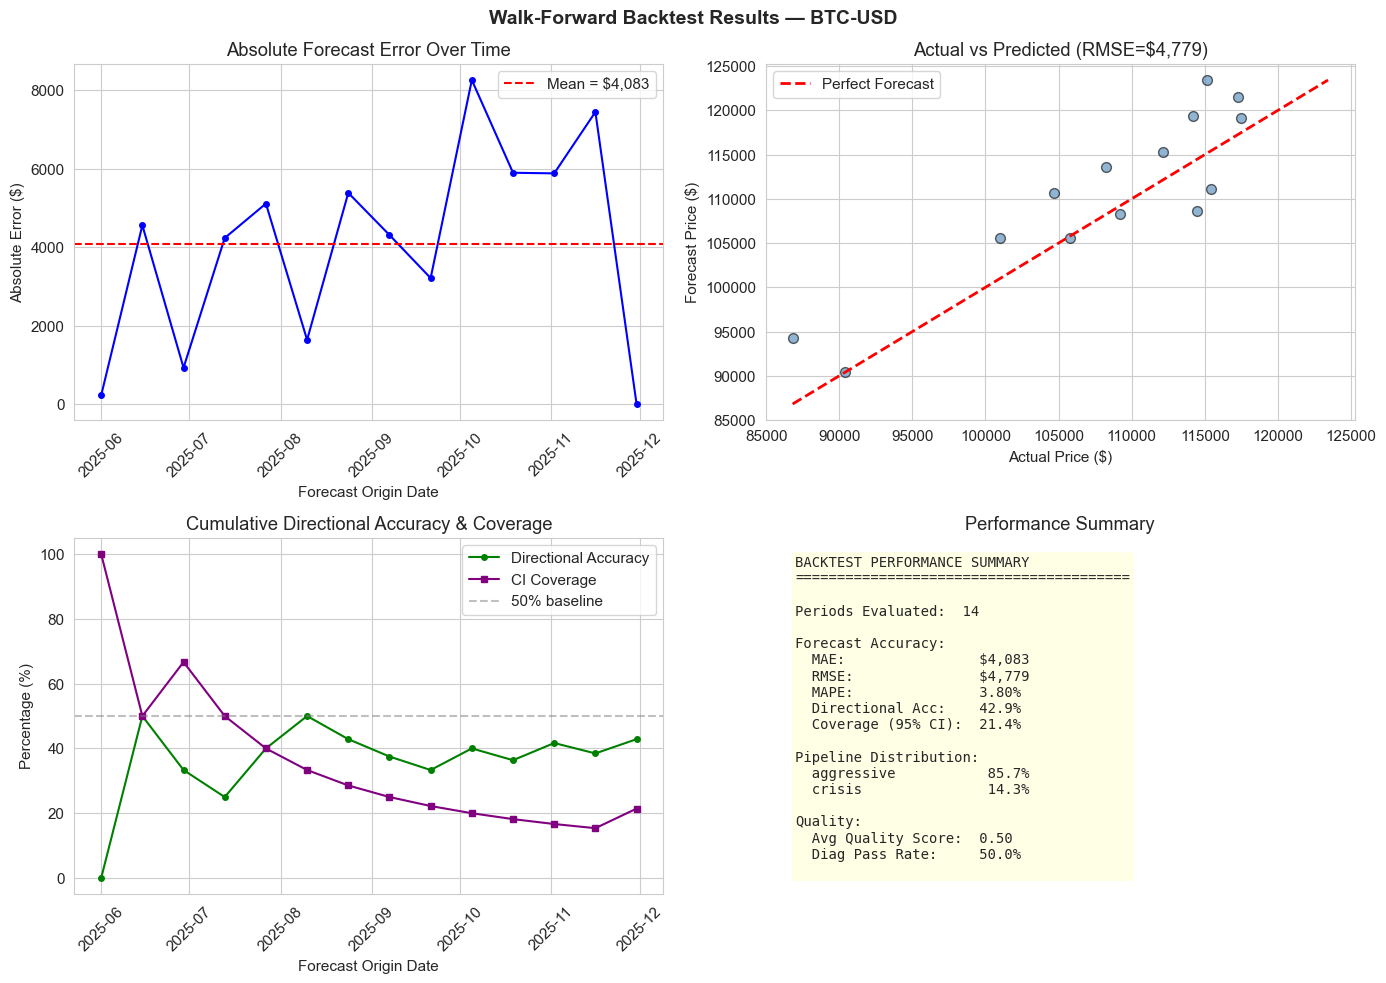

In [19]:
# ── Backtest Results Visualization ──
pr = backtest_result.period_results

if pr is not None and len(pr) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Rolling forecast error over time
    axes[0, 0].plot(pr['origin'], pr['abs_error'], 'o-', color='blue', markersize=4)
    axes[0, 0].axhline(y=pr['abs_error'].mean(), color='red', linestyle='--',
                       label=f'Mean = ${pr["abs_error"].mean():,.0f}')
    axes[0, 0].set_title('Absolute Forecast Error Over Time')
    axes[0, 0].set_ylabel('Absolute Error ($)')
    axes[0, 0].set_xlabel('Forecast Origin Date')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)

    # 2. Actual vs Predicted scatter
    axes[0, 1].scatter(pr['actual'], pr['forecast'], alpha=0.6, color='steelblue', edgecolors='black', s=50)
    min_val = min(pr['actual'].min(), pr['forecast'].min())
    max_val = max(pr['actual'].max(), pr['forecast'].max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Forecast')
    axes[0, 1].set_xlabel('Actual Price ($)')
    axes[0, 1].set_ylabel('Forecast Price ($)')
    axes[0, 1].set_title(f'Actual vs Predicted (RMSE=${backtest_result.rmse:,.0f})')
    axes[0, 1].legend()

    # 3. Cumulative directional accuracy & coverage
    cum_dir = pr['direction_correct'].expanding().mean() * 100
    cum_cov = pr['in_band'].expanding().mean() * 100
    axes[1, 0].plot(pr['origin'], cum_dir, 'o-', color='green', label='Directional Accuracy', markersize=4)
    axes[1, 0].plot(pr['origin'], cum_cov, 's-', color='purple', label='CI Coverage', markersize=4)
    axes[1, 0].axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
    axes[1, 0].set_title('Cumulative Directional Accuracy & Coverage')
    axes[1, 0].set_ylabel('Percentage (%)')
    axes[1, 0].set_xlabel('Forecast Origin Date')
    axes[1, 0].legend()
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Summary metrics text panel
    metrics_text = (
        f"BACKTEST PERFORMANCE SUMMARY\n"
        f"{'='*40}\n\n"
        f"Periods Evaluated:  {backtest_result.n_periods}\n\n"
        f"Forecast Accuracy:\n"
        f"  MAE:                ${backtest_result.mae:,.0f}\n"
        f"  RMSE:               ${backtest_result.rmse:,.0f}\n"
        f"  MAPE:               {backtest_result.mape:.2f}%\n"
        f"  Directional Acc:    {backtest_result.directional_accuracy:.1f}%\n"
        f"  Coverage (95% CI):  {backtest_result.coverage:.1f}%\n\n"
        f"Pipeline Distribution:\n"
    )
    for name, pct in sorted(backtest_result.pipeline_distribution.items(), key=lambda x: -x[1]):
        metrics_text += f"  {name:<20} {pct:.1f}%\n"
    metrics_text += (
        f"\nQuality:\n"
        f"  Avg Quality Score:  {backtest_result.avg_quality_score:.2f}\n"
        f"  Diag Pass Rate:     {backtest_result.diagnostics_pass_rate:.1f}%\n"
    )
    axes[1, 1].text(0.05, 0.95, metrics_text, fontsize=10, family='monospace',
                   verticalalignment='top', transform=axes[1, 1].transAxes,
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Performance Summary')

    plt.suptitle('Walk-Forward Backtest Results — BTC-USD', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print('No backtest periods evaluated. Check date range and data availability.')

**Interpretation:** The backtest validates MarketIntelligence on historical data using a walk-forward protocol (no future information leakage). **Forecast error** (top-left) shows how prediction accuracy varies across market conditions. **Actual vs predicted** (top-right) scatter should cluster near the diagonal — points far from it indicate large forecast misses. **Directional accuracy** (bottom-left) above 50% means the system predicts direction better than a coin flip, while **CI coverage** near 95% indicates well-calibrated confidence intervals. The **summary panel** (bottom-right) aggregates all key metrics. Note that cryptocurrency forecasting is inherently difficult — even modest directional accuracy represents genuine signal extraction.

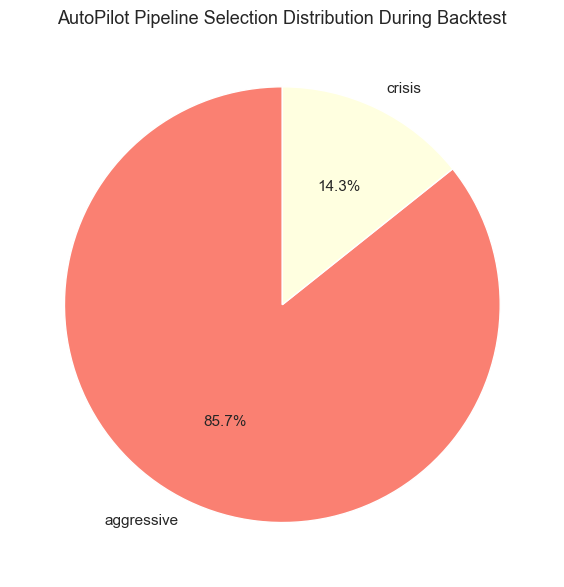

In [20]:
# ── Pipeline Distribution Pie Chart ──
if backtest_result.pipeline_distribution:
    fig, ax = plt.subplots(figsize=(8, 6))
    labels = list(backtest_result.pipeline_distribution.keys())
    sizes = list(backtest_result.pipeline_distribution.values())
    pipe_colors = {
        'conservative': 'lightblue', 'aggressive': 'salmon',
        'crisis': 'lightyellow', 'trend_following': 'lightgreen',
    }
    colors = [pipe_colors.get(l, 'lightgray') for l in labels]
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',
                                       colors=colors, startangle=90,
                                       textprops={'fontsize': 11})
    ax.set_title('AutoPilot Pipeline Selection Distribution During Backtest', fontsize=13)
    plt.tight_layout()
    plt.show()

**Interpretation:** This pie chart shows how the AutoPilot system distributed its pipeline selections across the backtest period. Different market conditions trigger different pipelines — the **aggressive** pipeline uses fractional differentiation for trending markets, **conservative** relies on standard Kalman smoothing, **crisis** adds extra safeguards, and **trend_following** exploits momentum. A diverse distribution indicates the system is adapting to changing conditions rather than defaulting to a single approach.